# Municipality Analysis

In [25]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import reverse_geocoder as rg 
import pprint 

In [26]:
df = pd.read_csv('nutritive.csv', index_col=False)
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
df.shape

(937785, 25)

## Utility Functions

In [28]:
#import os
#os.getcwd()
#from utils.utils import relocate
#from [dir].[file.py] import relocate
#from .utils imprt relocate

In [29]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
    
    return result[0]['admin1'], result[0]['name']

# Dataframe must have been given reset_indexed
# Complete missing values where deparment and municipality are unknown
def relocate(df_geo):
    n = df_geo.shape[0]
    for i in tqdm(range(0,n)):
        lat = df_geo.loc[i, 'lat']
        lon = df_geo.loc[i, 'lon']
        l2 = df_geo.loc[i, 'l2']
        l3 = df_geo.loc[i, 'l3']
        if (~np.isnan(lat) and ~np.isnan(lon)) and (pd.isnull(l3) or pd.isnull(l2)):
            df_geo.loc[i, 'l2'], df_geo.loc[i, 'l3'] = reverseGeocode((lat,lon))
            
    return df_geo

#Calculates missing data and shows dataframe
def calculate_missing(df):
    s_types = df.dtypes
    missing = df.isnull().sum()
    missing_per = (df.isnull().sum()/df.shape[0])*100

    explo = pd.DataFrame({'Type' : s_types, 'Missing' : missing,
                       'Missing%' : missing_per}).sort_values(by=['Missing%', 'Type'], ascending=False)

    return explo

#Graph missing data given dataframe
def graph_missing(df):

    df_missing = calculate_missing(df)

    df_missing = df_missing.where(df_missing['Missing%'] > 25).dropna(subset=['Missing%'])

    sns.barplot(x=df_missing.index, y=df_missing['Missing%'], data=df_missing)

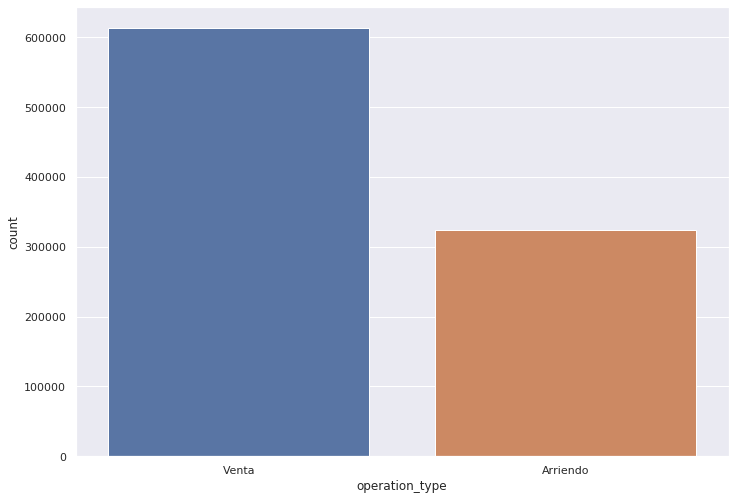

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})     
df = df.where(df['operation_type'] != 'Arriendo temporal')
sns.countplot(data = df, x = 'operation_type')

In [31]:
df_sell = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df_rent = df.where(df['operation_type'] == 'Arriendo').dropna(subset=['operation_type'])

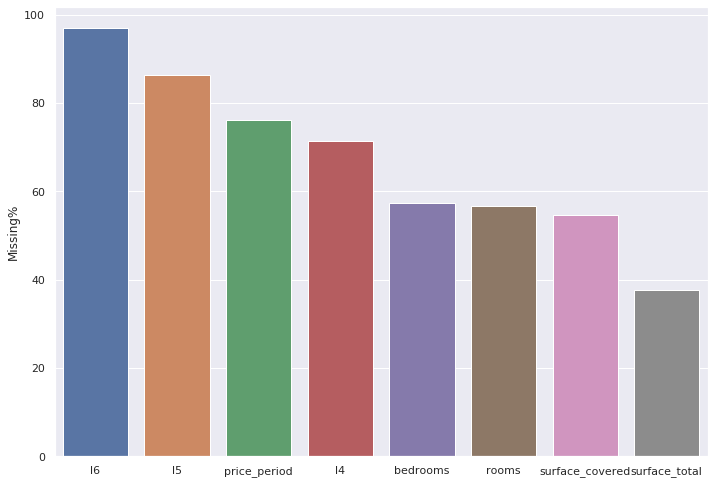

In [32]:
graph_missing(df_sell)

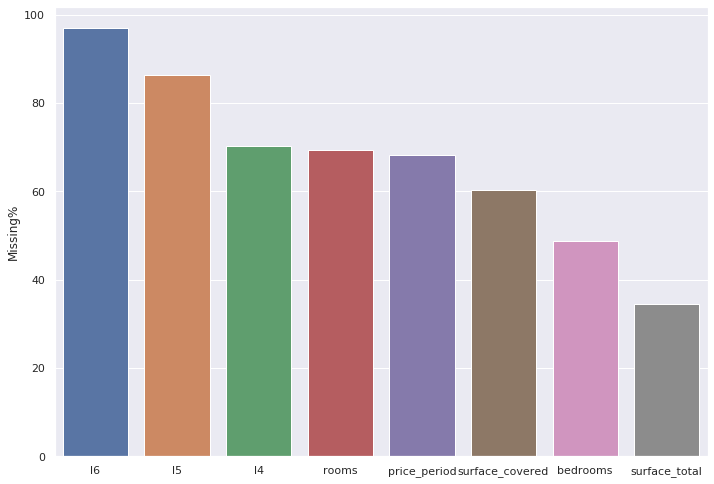

In [33]:
graph_missing(df_rent)

In [34]:
df_rent.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)
df_sell.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)

In [39]:
df_medellin = df_sell.where(df_sell['l3'] == 'Bogotá D.C').dropna(subset=['l3'])

def new_features(df):
    df_features = df.copy()
    df_features = df_features[df_features["end_date"].str.contains('9999')==False]
    df_features['price_m2'] = df['price'] / df['surface_total']
    df_features['end_date'] = pd.to_datetime(df_features.end_date)
    df_features['created_on'] = pd.to_datetime(df_features.created_on)
    df_features['delta_time'] = df_features['end_date'] - df_features['created_on'] 
    df_features['delta_time'] = df_features['delta_time'].dt.days
    
    return df_features
    
df_medellin = df_medellin[df_medellin['price']<df_medellin['price'].quantile(0.98)]
df_medellin = df_medellin[df_medellin['price'] > df_medellin['price'].quantile(0.2)]
df_medellin = df_medellin[df_medellin['surface_total'] > 0]

df_medellin = new_features(df_medellin)
df_medellin['price'] = np.log(df_medellin['price'])

del df_medellin['delta_time']


#hue='species'
#sns.pairplot(df_medellin, height=2.5);

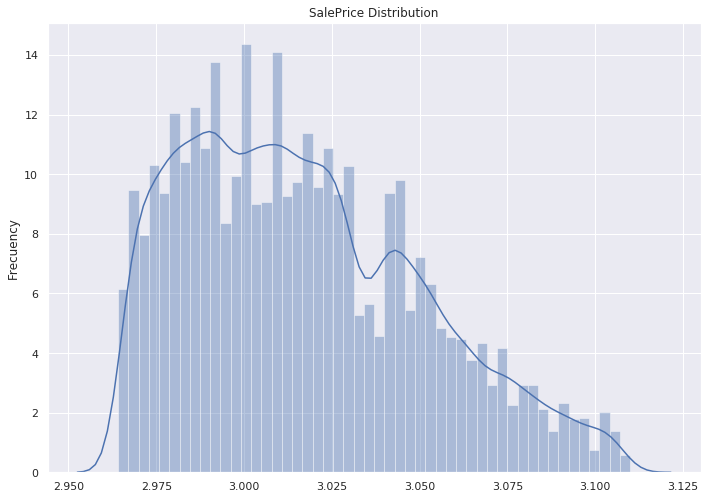

In [40]:
ax = sns.distplot(np.log(df_medellin['price']));
ax.set(xlabel='', ylabel='Frecuency',title ="SalePrice Distribution")
plt.show()

In [41]:
df_medellin = df_medellin.drop(columns=['id', 'ad_type', 'start_date', 'end_date', 'created_on',
                          'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'])

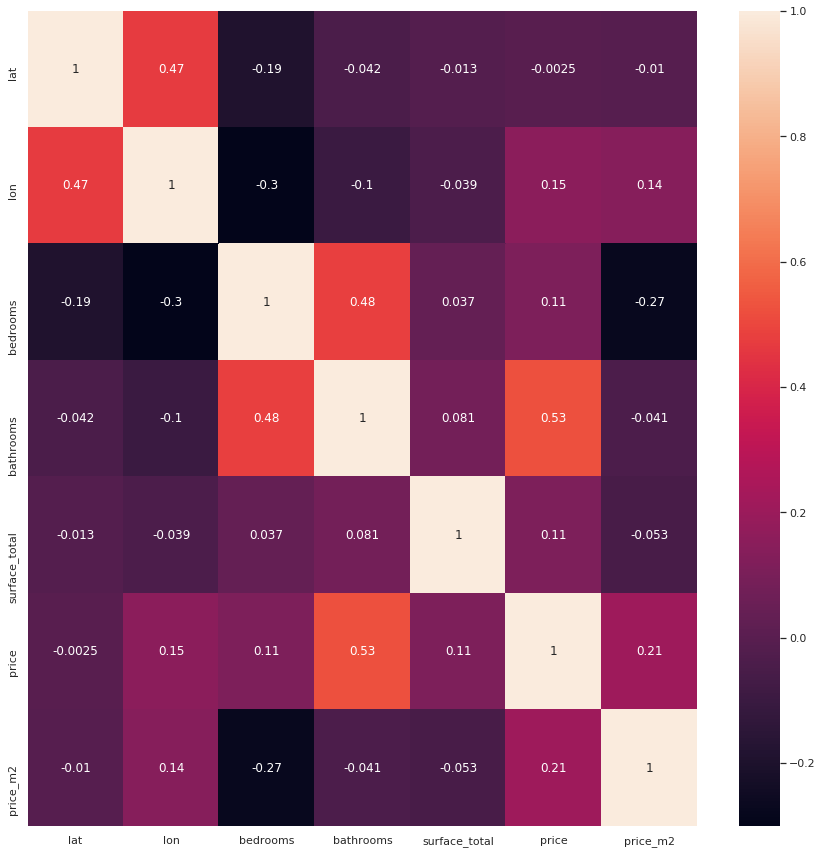

In [44]:
corr = df_medellin.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

## Machine Learning

In [45]:
X_df = df_medellin.drop('price', axis=1).copy()
Y_df = df_medellin['price'].copy()

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(X_df, Y_df, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [48]:
# Para eliminar SettingWithCopyWarning
X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [49]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

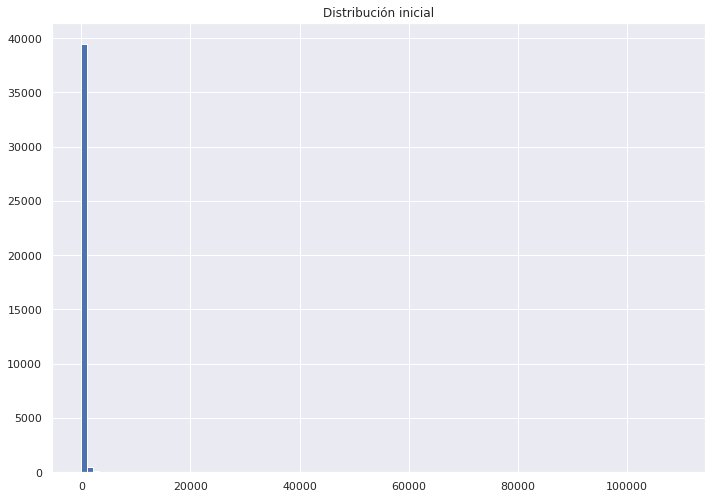

In [50]:
# Validar que todos los valores sean mayores a 0 para poder realizar la transformación.
(X_train["surface_total"]>0).sum() == len(X_train)
X_train["surface_total"].hist(bins=100)
plt.title("Distribución inicial")
plt.show()

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [51]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2
588762,4.716000,-74.123000,16.0,6.0,-0.872827,Casa,6.790123e+06
433625,4.661000,-74.049004,3.0,5.0,0.650393,Apartamento,7.659574e+06
780930,4.730784,-74.064182,4.0,5.0,-0.216035,Otro,7.642276e+06
358911,4.729000,-74.066000,4.0,4.0,-0.080702,Apartamento,4.666667e+06
702592,4.705000,-74.056000,3.0,3.0,-0.204111,Casa,4.435484e+06


In [52]:
box_cox.lambdas_ # Lambdas aprendidos

array([-0.30428213])

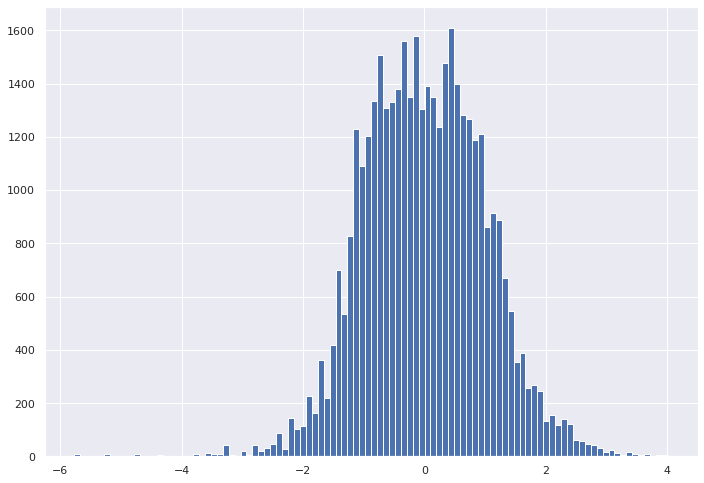

In [53]:
# Visualización de distribución
X_train["surface_total"].hist(bins=100)
plt.show()
# Se aproxima en gran medida a una distribución normal visualmente
# Nótese que los datos están centrados en 0 y pareciera que tiene desviación unitaria.

### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [54]:
print("Classes: ", X_train['property_type'].unique()) # Clases categoricas
X_train.head()

Classes:  ['Casa' 'Apartamento' 'Otro' 'Local comercial' 'Oficina' 'Depósito' 'Lote'
 'Finca' 'Parqueadero']


,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2
588762,4.716000,-74.123000,16.0,6.0,-0.872827,Casa,6.790123e+06
433625,4.661000,-74.049004,3.0,5.0,0.650393,Apartamento,7.659574e+06
780930,4.730784,-74.064182,4.0,5.0,-0.216035,Otro,7.642276e+06
358911,4.729000,-74.066000,4.0,4.0,-0.080702,Apartamento,4.666667e+06
702592,4.705000,-74.056000,3.0,3.0,-0.204111,Casa,4.435484e+06


In [55]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [56]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

In [57]:
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
588762,4.716000,-74.123000,16.0,6.0,-0.872827,6.790123e+06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433625,4.661000,-74.049004,3.0,5.0,0.650393,7.659574e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780930,4.730784,-74.064182,4.0,5.0,-0.216035,7.642276e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
358911,4.729000,-74.066000,4.0,4.0,-0.080702,4.666667e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702592,4.705000,-74.056000,3.0,3.0,-0.204111,4.435484e+06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tratamiento de datos faltantes o NaN

In [58]:
from sklearn.impute import SimpleImputer
# NaNs Columns
X_train.isnull().sum()

lat                    5051
lon                    5051
bedrooms              13514
bathrooms              2932
surface_total             0
price_m2                  0
op_Apartamento            0
op_Casa                   0
op_Depósito               0
op_Finca                  0
op_Local comercial        0
op_Lote                   0
op_Oficina                0
op_Otro                   0
op_Parqueadero            0
dtype: int64

In [59]:
#Using Simple Imputer

si_bedrooms = SimpleImputer(strategy='median')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='median')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='median')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='median')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [60]:
#Otras transformaciones
cols2scale = ['lon', 'lat', 'bedrooms', 'bathrooms', 'price_m2']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
588762,0.651691,-1.649586,5.455824,1.970648,-0.872827,0.177244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433625,-0.537440,0.572042,-0.154635,1.272718,0.650393,0.316541,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780930,0.971323,0.116334,0.276939,1.272718,-0.216035,0.313770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
358911,0.932757,0.061751,0.276939,0.574787,-0.080702,-0.162961,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702592,0.413865,0.361986,-0.154635,-0.123144,-0.204111,-0.200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [62]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [63]:
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)

In [64]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [65]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [66]:
assert (X_test.columns.values == X_train.columns.values).all()

In [67]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
932853,-0.358634,-1.415403,0.276939,0.574787,0.810688,-0.088711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
646125,-0.681853,0.557668,-0.154635,-0.821075,-0.135107,0.075304,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695722,0.356052,-0.437809,-0.154635,-0.123144,-0.383569,0.065221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874264,0.136198,0.253912,-0.154635,0.574787,-0.102144,0.065111,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433979,-2.777360,-1.597555,-0.154635,-0.123144,3.163246,-0.830515,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583818,-0.213128,0.241892,-0.154635,0.574787,0.738760,0.165908,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459161,-0.403170,-0.026127,0.708513,1.970648,1.467178,-0.462025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250693,0.032130,0.758106,-1.017783,-1.519005,-1.097933,-0.188535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
752868,0.435233,1.098596,-0.154635,-0.821075,-0.629173,-0.228864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
lin_reg.intercept_, lin_reg.coef_

(20.45270451457906,
 array([-0.02289226,  0.11965911, -0.06425742,  0.0900133 ,  0.5769337 ,
         0.26152152,  0.01973557, -0.16607855, -0.01633782, -0.45584281,
         0.38521369, -0.18754248,  0.2853485 ,  0.04798484,  0.08751906]))

In [69]:
Y_test_estimate = lin_reg.predict(X_test)

In [70]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [71]:
rmse = mean_squared_error(Y_test, Y_test_estimate, squared=True)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))

Root Mean Square Error (RMSE)= 0.12


In [72]:
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))

Mean Absolute Error (MAE)= 0.24


In [79]:
r2 = r2_score(Y_test, Y_test_estimate)
print("R_2 = {:.3f}".format(r2))

R_2 = 0.787


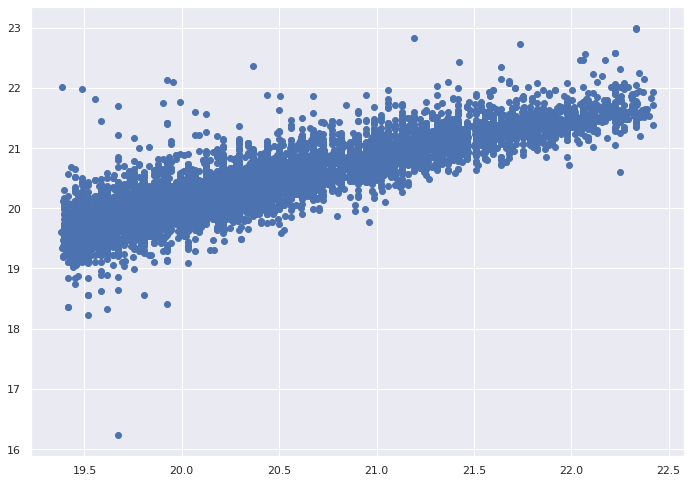

In [77]:
plt.scatter(Y_test, Y_test_estimate)